# LSTM Tests 
This notebook will be a series of tests on the data that evaluate the potential of an LSTM model in forecasting the severity of an outbreak.

Tasks:  

1. MaxMin Scaler
2. Experiment with window size
3. Experiment with model architectures
4. Experiment with z-scores  

RMSE vs. Accuracy


In [2]:
%run data_preprocessing.ipynb

<Figure size 640x480 with 1 Axes>

Benin
Statistics=8.803, p=0.012
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Burkina Faso
Statistics=33.110, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Ivory Coast
Statistics=88.425, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Ghana
Statistics=117.618, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Mali
Statistics=1.080, p=0.583
Sample looks Gaussian (fail to reject H0)


<Figure size 640x480 with 1 Axes>

Mauritania
Statistics=130.257, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Nigeria
Statistics=45.750, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Senegal
Statistics=5.775, p=0.056
Sample looks Gaussian (fail to reject H0)


<Figure size 640x480 with 1 Axes>

Chad
Statistics=67.856, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Togo
Statistics=102.898, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Cameroun
Statistics=9.514, p=0.009
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Guinea
Statistics=45.050, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Sudan
Statistics=13.657, p=0.001
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Niger
Statistics=103.552, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Centrafrique
Statistics=36.278, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

South Sudan
Statistics=108.957, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Gambia
Statistics=60.517, p=0.000
Sample does not look Gaussian (reject H0)


<Figure size 640x480 with 1 Axes>

Dem. Rep. Congo
Statistics=5.683, p=0.058
Sample looks Gaussian (fail to reject H0)


<Figure size 640x480 with 1 Axes>

Ethiopia
Statistics=0.431, p=0.806
Sample looks Gaussian (fail to reject H0)


<Figure size 640x480 with 1 Axes>

Tanzania
Statistics=16.171, p=0.000
Sample does not look Gaussian (reject H0)
2700


In [233]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import *
import pandas 
import numpy
import random
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [234]:
class MeningitisDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [162]:
""" Notes
1. Recurrent modules from nn will take a sequence and output a sequence of the same length - if building a many to one
then can take last output of the sequence
2. num_directions from documentation is 1 or 2 based on whether lstm is uni or bidirectional

Input will by default have shape [seq_length, batch_size, features]
Hidden state will have dimension [num_layers, batch_size, hidden_size]
Output will by default have shape [seq_length, batch_size, hidden_size]
"""
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=10, output_dim=3, batch_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_dim
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_dim, hidden_dim, 1, dropout=0.5)

        self.linear = nn.Linear(hidden_dim, output_dim)
        self.hidden_cell = (torch.randn(1, self.batch_size, hidden_dim),
                            torch.randn(1, self.batch_size, hidden_dim))
    def forward(self, x):
        out_lstm, hidden_states = self.lstm(x.view(len(x[0]), self.batch_size, 1), self.hidden_cell)
        #must call .contiguous because we are using mini-batches
        out_lstm = out_lstm.contiguous().view(-1, self.hidden_layer_size)
        predictions = self.linear(out_lstm)
        #not sure if this is the right way to do it for a mini-batch since can't do predictions[-1]
        return predictions[-self.batch_size:]
    

In [239]:
#Reshape input
data = []
for i in range(len(input_data)):
    feature, label = input_data[i]
    feature = torch.FloatTensor(feature).view(-1)
    data.append((feature, label))


#shuffle the data and separate it into training and testing
random.shuffle(data)
separation = int(0.8 * len(data))
input_train_data = data[:separation]
input_test_data = data[separation:]
train_data = MeningitisDataset(input_train_data)
test_data = MeningitisDataset(input_test_data)
train_loader = DataLoader(train_data, batch_size = 1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

dtype = torch.LongTensor
model = LSTM(batch_size=1)
model.dtype = dtype
loss_function = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
print(model)

LSTM(
  (lstm): LSTM(1, 10, dropout=0.5)
  (linear): Linear(in_features=10, out_features=3, bias=True)
)


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch  0  loss:  tensor(0.7543, grad_fn=<NllLossBackward>)
Epoch  25  loss:  tensor(0.9888, grad_fn=<NllLossBackward>)
Epoch  50  loss:  tensor(1.0848, grad_fn=<NllLossBackward>)
Epoch  75  loss:  tensor(0.7531, grad_fn=<NllLossBackward>)
Epoch  100  loss:  tensor(0.4848, grad_fn=<NllLossBackward>)
Epoch  125  loss:  tensor(0.5736, grad_fn=<NllLossBackward>)


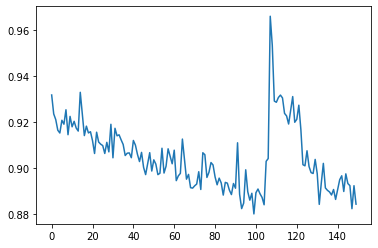

In [243]:
#Training
num_epochs = 50
loss_values = []
for epoch in range(100):
    clip = 5
    running_loss = 0
    for idx, sample in enumerate(train_loader):
        optimizer.zero_grad()
        sample[0] = sample[0]
        scores = model(sample[0]).view(-1, 3)
        label = sample[1]
        loss = loss_function(scores, label)
        #backprop and calculate gradients
        loss.backward()
        #to prevent exploding gradient problem in LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        #update weights
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    if epoch%25 == 0:
        print("Epoch ", epoch, " loss: ", loss)

plt.plot(loss_values)

In [244]:
def check_accuracy(model, loader): 
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    sum_rmse = 0
    for idx, sample in enumerate(loader):
        x = sample[0]
        y = sample[1]
        scores = model(x)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        sum_rmse += np.sqrt(mean_squared_error(preds, y.unsqueeze(-1)))*y.shape[0]
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print("RMSE Loss: ", sum_rmse/num_samples)

In [245]:
check_accuracy(model, test_loader)

Got 248 / 540 correct (45.93)
RMSE Loss:  0.7
